## Hand-coded neural network - currently only coded for continuous targets, regression-style.

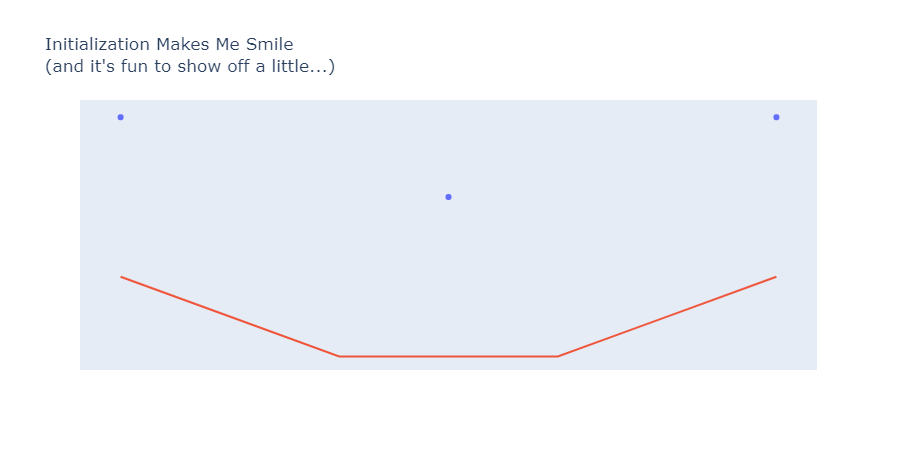

In [1]:
import math
import numpy as np
import datetime as dt
import pandas as pd
import ipdb

import chart_studio.plotly as ply
import chart_studio.tools as plytool
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as plyoff

# plotly initialization
# if using jupyter lab, must have the plotly extension installed: https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension
# jupyter labextension install @jupyterlab/plotly-extension
plyoff.init_notebook_mode(connected=True)
x1 = [1,4,7]; y1 = [7,5,7]
x2 = [1,2,3,4,5,6,7]; y2 = [3,2,1,1,1,2,3]
plyoff.iplot(go.Figure(data=[go.Scatter({"x":x1, "y":y1, 'mode':'markers'}),
                             go.Scatter({"x":x2, "y":y2, 'mode':'lines'})],
                                        layout=go.Layout(autosize=False,width=500,title="Initialization Makes Me Smile<br>(and it's fun to show off a little...)",
                                                         showlegend=False, xaxis={'showgrid':False, 'showticklabels':False},
                                                         yaxis={'showgrid':False, 'showticklabels':False})))

In [2]:
class NeuralNet():
    def __init__(self, nodeCounts, activations, learnRate, lossFunc, randState):
        '''
        Initialize the neural net. Note that the input data is assumed to be transposed from
        the usual nxp shape, so that input node i represents all observations for feature i.
        Inputs are:
            nodeCounts: list of node counts per layer
            activations: list of activations for each layer (just use None for the input layer);
                choices are sigmoid, tanh, relu, leakyrelu, softmax, and linear
            learnRate: learning rate for back propagation
            lossFunc: loss function, currently only MSE is implemented
            randState: seed for the the randomizer
        Other useful attributes are:
            N: number calculation layers
            hiddenLayers: number of hidden layers (duh!)
            Z: list of arrays of linear combination part of activation calculation
            A: list of arrays of final activation values
        '''
        self.randState = randState       # random state
        self.lossFunc = lossFunc         # loss function name
        self.learnRate = learnRate       # back propagation learning rate
        self.nodeCounts = nodeCounts     # list of node counts per layer
        self.inpNodes = nodeCounts[0]    # number input nodes
        self.hidNodes = nodeCounts[1:-1] # list of number of nodes in hidden layers
        self.outNodes = nodeCounts[-1]   # number output nodes
        self.N = len(nodeCounts)-1       # number calculation layers
        self.hiddenLayers = self.N-1     # number of hidden layers
        self.Z = [None]*(self.N+1)       # linear combination values (Z)
        self.A = [None]*(self.N+1)       # activation values (A)
        self.G = [None]*(self.N+1)       # gradients
        
        # check if softmax is used and warn
        if 'softmax' in activations:
            print('Warning, the gradient of softmax has not yet been implemented, but is hardcoded to 0.5. Use at your own risk!')
            
        # check if loss is not MSE & warn
        if self.lossFunc != 'MSE':
            print('Warning, the only loss function currently implemented is MSE, the value & gradient is hardcoded at 0.5. Use at your own risk!')
        
        # set the random state
        if randState is None:
            self.randState = math.ceil((dt.datetime.now() - dt.datetime(2018,6,19)).total_seconds())
        np.random.seed(self.randState)

        # loop through and build each of the layers
        layerCounts = len(nodeCounts)
        self.layers = [None]*layerCounts
        prevM = nodeCounts[0]
        for l in range(layerCounts):
            if l == 0:
                pass # this is the input node, so just let the parameters & gradients stay None
            else:
                # randomly initialize the weights & biases
                w = np.random.uniform(size=(nodeCounts[l],prevM))-0.5
                b = np.random.uniform(size=(nodeCounts[l],1))-0.5
                # put it all together
                self.layers[l] = {'ws':w, 'bs':b, 'func':activations[l]}
                # initialize to zero the gradients
                self.G[l] = {'ws':np.zeros(shape=(nodeCounts[l],prevM), dtype=float),
                                     'bs':np.zeros(shape=(nodeCounts[l],1), dtype=float)}
                # set the previous layer number nodes to this one
                prevM = nodeCounts[l]
            
    def __str__(self):
        res = 'Random State = %d\nLoss = %s\nLearning Rate = %0.3f\n%d hidden layers\n%d input nodes'\
            %(self.randState,self.lossFunc,self.learnRate,self.hiddenLayers,self.inpNodes)
        for i,l in enumerate(self.layers[1:]):
            if (i==self.hiddenLayers):
                res += '\noutput layer (%s), %d nodes:\n\tw=%r\n\tb=%r'%(l['func'],len(l['bs']),l['ws'],l['bs'])
            else:
                res += '\nlayer %d (%s), %d nodes:\n\tw=%r\n\tb=%r'%(i+1,l['func'],len(l['bs']),l['ws'],l['bs'])
        res += '\nOutput value: %r'%self.A[-1]
        return res
    
    def print(self, verbose=False):
        if verbose:
            res = self.__str__()
        else:
            res = 'Random State = %d\nLoss = %s\nLearning Rate = %0.3f\n%d hidden layers\n%d input nodes'\
                %(self.randState,self.lossFunc,self.learnRate,self.hiddenLayers,self.inpNodes)
            for i,l in enumerate(self.layers[1:]):
                if (i==self.hiddenLayers):
                    res += '\noutput layer %d nodes: %s(w=%r, b=%r)'%(len(l['bs']),l['func'],l['ws'].shape,l['bs'].shape)
                else:
                    res += '\nlayer %d, %d nodes: %s(w=%r, b=%r)'%(i+1,len(l['bs']),l['func'],l['ws'].shape,l['bs'].shape)
            res += '\nOutput value: %r'%self.A[-1]
        return res
    
    def computeNode(self, prevA, layer):
        ''' Compute the activation values for all nodes in a layer.'''
        Z = np.dot(layer['ws'],prevA)+layer['bs']
        return Z, self.computeActivation(layer['func'], Z, gradient=False)
                    
    def computeActivation(self, func, Z, gradient=False):
        '''
        Compute either the value of the activation function, or it's gradient
        wrt the input Z. Function choices are: sigmoid, tanh, relu, leakyrelu,
        softmax(not coded), and linear. Sigmoid & tanh not used often in hidden
        layers due to vanishing gradients; relu should not be used in the output
        layer; softmax is for classification, linear is for regression.
        '''
        if gradient:
            # compute the value of the activation function gradient for z; result is partial_a/partial_z
            if func == 'sigmoid':
                sigm = 1.0 + np.exp(-Z)
                result = np.exp(-Z)/(sigm**2)
            elif func == 'tanh':
                result = 1-np.tanh(Z)**2
            elif func == 'relu':
                result = Z > 0
            elif func == 'leakyrelu':
                alpha = 0.01 # might want to make this a parameter at some point
                result = Z > 0
                result[result==0] = alpha
            elif func == 'softmax':
                print('Softmax gradient not yet implemented!')
                result = 0.5
            elif func == 'linear':
                result = 1.0
        else:
            # compute the value of the activation function for z; result is a
            if func == 'sigmoid':
                result = 1.0/(1.0+np.exp(-Z))
            elif func == 'tanh':
                result = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))
            elif func == 'relu':
                result = np.maximum(0,Z)
            elif func == 'leakyrelu':
                alpha = 0.01 # might want to make this a parameter at some point
                result = np.maximum(0, Z) - alpha*np.maximum(0, -Z)
            elif func == 'softmax':
                result = np.exp(Z)/np.sum(Z, axis=1, keepdims=True)
            elif func == 'linear':
                result = Z
        return result
    
    def forwardPropagate(self, X):
        ''' Propagate forward through the network from the inputs to the output layer. '''
        self.A[0] = X
        # loop throught the layers
        for i,l in enumerate(self.layers[1:]):
            self.Z[i+1], self.A[i+1] = self.computeNode(self.A[i], l)
        return self.A[-1]
    
    def computeLoss(self, y, gradient=False):
        ''' Compute either the value of the loss function, or it's gradient wrt
        the output layer activation value. Currently, MSE (half MSE, in fact) is the
        only choice. '''
        if gradient:
            if self.lossFunc == 'MSE':
                result = -np.mean(y-self.A[-1],axis=1,keepdims=True)
                result = -(y-self.A[-1])
            else:
                result = 0.5
        else:
            if self.lossFunc == 'MSE':
                result = np.mean((y - self.A[-1])**2)/2
            else:
                result = 0.5
        return result
    
    def backPropagate(self, y):
        ''' Propagate prediction errors backward through the network from the outputs to the input layer.'''
        m = y.shape[1]
        # partial of loss wrt final activation
        partial_E_aN = self.computeLoss(y, gradient=True)
                       
        # first compute the gradients for the output layer
        # partial of this layer's activation wrt this layer's z
        Al_Zl = self.computeActivation(self.layers[-1]['func'], self.Z[-1], gradient=True)
        # partial of this layer's z wrt previous layer's activation
        Zl_Alm1 = self.layers[-1]['ws']
        z = partial_E_aN*Al_Zl                 # element-wise multiplication
        b = np.mean(z, axis=1, keepdims=True)  # average across observations
        w = np.dot(z, self.A[-2].T)/m          # scaled by number observations
        self.G[-1] = {'Al_Zl':Al_Zl,'Zl_Alm1':Zl_Alm1,'zs':z,'ws':w, 'bs':b}
   
        # iterate over the hidden layers in reverse order
        for l in range(self.N-1, 0, -1):
            thisLayer = self.layers[l]
            # partial of activation wrt z
            Al_Zl = self.computeActivation(thisLayer['func'], self.Z[l], gradient=True)
            # partial of z wrt previous layer's activation
            Zl_Alm1 = thisLayer['ws']
            # gradient is built up by sequential multiplication, and the basis is the higher level's z gradients
            z = np.dot(self.G[l+1]['Zl_Alm1'].T, self.G[l+1]['zs'])*Al_Zl
            b = np.mean(z, axis=1, keepdims=True)
            w = np.dot(z, self.A[l-1].T)/m
            self.G[l] = {'Al_Zl':Al_Zl,'Zl_Alm1':Zl_Alm1,'zs':z,'ws':w,'bs':b}
        
        # finally, traverse the network forward to update the parameters
        for l in range(self.N+1):
            if l == 0:
                pass # this is the input node, so just skip
            else:
                # update bs
                self.layers[l]['bs'] -= self.learnRate*self.G[l]['bs']
                # update ws
                self.layers[l]['ws'] -= self.learnRate*self.G[l]['ws']
    
    def execute(self, X, y, epochs, talkFreq=0.1, plotLoss=True):
        '''
        Iterate on forward and backward propagation for a specified number of epochs.
        Inputs are:
            X: input data as (n_0,m) array, where n_0 = nodeCounts[0], and m is the number observations
            y: target data as (n_(N+1),m) array where n_(N+1) = nodeCounts[-1], and m is the number observations
            epochs: number of iterations
            talkFreq: % of epochs on which model performance should be reported; completely silent if None
            plotLoss: if True, return a plotly figure plotting loss by epochs
        '''
        self.epochs = epochs
        try:
            verb = talkFreq*epochs
        except TypeError:
            verb = np.inf # this happens if talkFreq is None, indicating silent running
        losss = [None]*epochs
        for i in range(epochs):
            # forward propagate
            yhat = self.forwardPropagate(X)
            # compute loss
            losss[i] = self.computeLoss(y)
            # back propagate, maybe
            if i != (epochs-1):
                self.backPropagate(y)
            # talk, maybe
            if (talkFreq is not None) & (i%verb==0):
                print('Epoch %d %s = %0.5f'%(i,self.lossFunc,losss[i]))
        # print the final result, maybe
        if talkFreq is not None:
            print('After %d Epochs, final %s is %0.5f'%(epochs,self.lossFunc,losss[-1]))
        # generate a plot, maybe
        if plotLoss:
            self.fig = go.Figure(data=[go.Scatter({'x':list(range(epochs)), 'y':losss, 'name':self.lossFunc})],
                layout=go.Layout({'title':'%s by Epoch'%mynet.lossFunc, 'xaxis':{'title':'epoch'}, 'yaxis':{'title':self.lossFunc}}))
        else:
            self.fig = None
        return losss, self.fig

In [3]:
# setup data
m = 10
p = 2
k = 2
np.random.seed(42)
X = np.random.uniform(size=(p,m)) # x has m observations and p features
y = np.random.uniform(size=(k,m)) # y has m observations and k features
print('y=%r'%y)

# setup the network
nodeCounts = [p, 5, 10, 20, 10, 5, k] # output node counts should match number features in y
activations = [None,'tanh','tanh','tanh','tanh','tanh','linear']
randomState = 42
learningRate = 0.01
lossFunction = 'MSE'
mynet = NeuralNet(nodeCounts, activations, learningRate, lossFunction, randomState)
print(mynet.print(verbose=False))

y=array([[0.61185289, 0.13949386, 0.29214465, 0.36636184, 0.45606998,
        0.78517596, 0.19967378, 0.51423444, 0.59241457, 0.04645041],
       [0.60754485, 0.17052412, 0.06505159, 0.94888554, 0.96563203,
        0.80839735, 0.30461377, 0.09767211, 0.68423303, 0.44015249]])
Random State = 42
Loss = MSE
Learning Rate = 0.010
5 hidden layers
2 input nodes
layer 1, 5 nodes: tanh(w=(5, 2), b=(5, 1))
layer 2, 10 nodes: tanh(w=(10, 5), b=(10, 1))
layer 3, 20 nodes: tanh(w=(20, 10), b=(20, 1))
layer 4, 10 nodes: tanh(w=(10, 20), b=(10, 1))
layer 5, 5 nodes: tanh(w=(5, 10), b=(5, 1))
output layer 2 nodes: linear(w=(2, 5), b=(2, 1))
Output value: None


Epoch 0 MSE = 0.06866
Epoch 100 MSE = 0.03785
Epoch 200 MSE = 0.03736
Epoch 300 MSE = 0.03684
Epoch 400 MSE = 0.03626
Epoch 500 MSE = 0.03559
Epoch 600 MSE = 0.03481
Epoch 700 MSE = 0.03387
Epoch 800 MSE = 0.03276
Epoch 900 MSE = 0.03143
After 1000 Epochs, final MSE is 0.02992


,y_1,yhat_1,y_2,yhat_2,Error_1,Error_2
0,0.611853,0.418563,0.607545,0.609508,0.193290,-0.001963
1,0.139494,0.373135,0.170524,0.345736,-0.233641,-0.175212
2,0.292145,0.381360,0.065052,0.385238,-0.089215,-0.320186
3,0.366362,0.405999,0.948886,0.560186,-0.039637,0.388699
4,0.456070,0.418829,0.965632,0.573308,0.037241,0.392324
5,0.785176,0.418774,0.808397,0.572907,0.366402,0.235491
6,0.199674,0.416762,0.304614,0.541457,-0.217088,-0.236844
7,0.514234,0.388385,0.097672,0.473681,0.125849,-0.376009
8,0.592415,0.398421,0.684233,0.502356,0.193994,0.181877
9,0.046450,0.400275,0.440152,0.538325,-0.353824,-0.098172


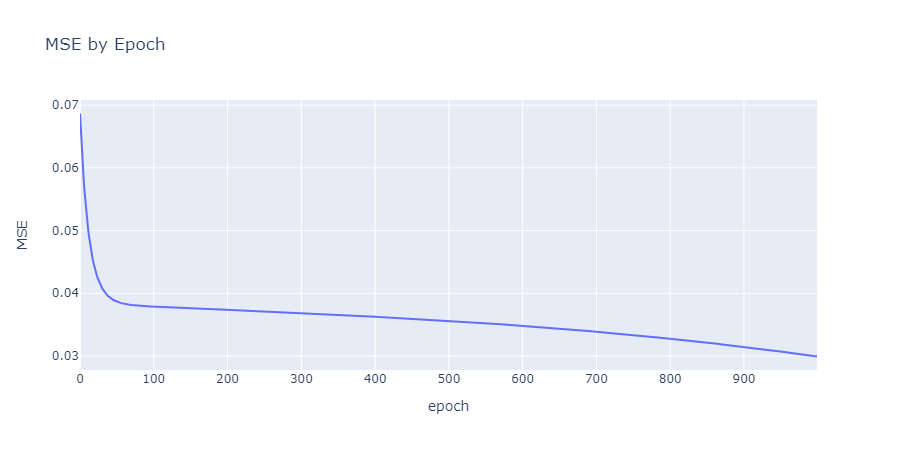

In [4]:
''' fit the neural network '''
# iterate forward & backward propagation
epochs = 1000    # number of iterations of forward propagation - loss calculation - backward propagation
verb = 0.1       # how often to report results
losses,fig = mynet.execute(X, y, epochs, verb, True)

# display results
yhat = mynet.forwardPropagate(X)
res = pd.DataFrame({'y_1':y[0,:], 'yhat_1':yhat[0,:], 'y_2':y[1,:], 'yhat_2':yhat[1,:]})
res['Error_1'] = res.y_1 - res.yhat_1
res['Error_2'] = res.y_2 - res.yhat_2
display(res)

# display results visually
plyoff.iplot(fig)

In [5]:
# test robustness of the network wrt random initialization
M = 100
epochs = 100
states = np.rint(np.random.uniform(size=M)*10000).astype(int)
nets = [None for i in range(M)]
losses = [0]*M
for i in range(M):
    # create network
    nets[i] = NeuralNet(nodeCounts, activations, learningRate, lossFunction, states[i])
    losses[i] = nets[i].execute(X, y, epochs, None, False)[0][-1]
outputs = pd.DataFrame(losses,columns=['Output'])
display(outputs.describe())

,Output
count,100.000000
mean,0.038572
std,0.002295
min,0.032681
25%,0.037025
50%,0.038516
75%,0.039828
max,0.044171
